# Project Info

## Data source

The dataset used in this project comes from Mendeley Data and has been preprocessed by the user vmohammedraiyyan to focus on maternal health features.

Kaggle version of the dataset:
https://www.kaggle.com/datasets/vmohammedraiyyan/maternal-health-and-high-risk-pregnancy-dataset/data

Original Mendeley dataset:
https://data.mendeley.com/datasets/8k9pvpmykk/1

# Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import kagglehub

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split, RandomizedSearchCV

c:\Users\nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [2]:
path = kagglehub.dataset_download("vmohammedraiyyan/maternal-health-and-high-risk-pregnancy-dataset")
csv_files = glob.glob(os.path.join(path, "*.csv"))

100%|██████████| 8.98k/8.98k [00:00<00:00, 9.21MB/s]

Extracting files...


In [3]:
df = pd.read_csv(csv_files[0])

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r'\s+', '_', regex=True)
)

# Data Preparation

## Shape

In [4]:
print(f'Rows      :    {df.shape[0]}')
print(f'Columns   :    {df.shape[1]}')

Rows      :    1205
Columns   :    12


## Data types

In [5]:
df.dtypes

age                         int64
systolic_bp               float64
diastolic                 float64
bs                        float64
body_temp                   int64
bmi                       float64
previous_complications    float64
preexisting_diabetes      float64
gestational_diabetes        int64
mental_health               int64
heart_rate                float64
risk_level                 object
dtype: object

Convert target to binary

In [6]:
df.risk_level = df.risk_level.map({
    'Low': 0,
    'High': 1
})

## Check for nulls

In [7]:
# Count nulls
null_counts = df.isnull().sum()
total_rows = df.shape[0]

# List results
print("🧭 Columns with missing values:")
for col, count in null_counts[null_counts > 0].items():
    pct = (count / total_rows) * 100
    print(f"  {col} ({df[col].dtype}): {count} nulls ({pct:.2f}%)")

# Check rows with at least one null
rows_with_null = df.isna().any(axis=1).sum()
pct_rows_with_null = (rows_with_null / total_rows) * 100

print(f"\nTotal rows: {total_rows}")
print(f"Rows with ≥1 null value: {rows_with_null} ({pct_rows_with_null:.2f}%)")

# Automatically drop rows if < 5% missing
if pct_rows_with_null < 5:
    df = df.dropna()
    print(f"\n✅ Dropped rows with nulls ({pct_rows_with_null:.2f}% < 5%)")
    print(f"Remaining rows: {df.shape[0]}")
else:
    print(f"\n⚠️ Skipped dropping — missing rows exceed 5% ({pct_rows_with_null:.2f}%)")

🧭 Columns with missing values:
  systolic_bp (float64): 5 nulls (0.41%)
  diastolic (float64): 4 nulls (0.33%)
  bs (float64): 2 nulls (0.17%)
  bmi (float64): 18 nulls (1.49%)
  previous_complications (float64): 2 nulls (0.17%)
  preexisting_diabetes (float64): 2 nulls (0.17%)
  heart_rate (float64): 2 nulls (0.17%)
  risk_level (float64): 18 nulls (1.49%)

Total rows: 1205
Rows with ≥1 null value: 39 (3.24%)

✅ Dropped rows with nulls (3.24% < 5%)
Remaining rows: 1166


# Exploratory Data Analysis

## Summary

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1166.0,27.505146,9.251538,10.0,21.000,25.0,31.75,65.0
systolic_bp,1166.0,116.876501,18.725811,70.0,100.000,120.0,130.00,200.0
diastolic,1166.0,77.278731,14.287736,40.0,65.000,80.0,90.00,140.0
bs,1166.0,7.522273,3.059662,3.0,6.000,6.9,7.90,19.0
body_temp,1166.0,98.384220,1.074028,97.0,98.000,98.0,98.00,103.0
bmi,1166.0,23.339280,3.886486,0.0,20.925,23.0,25.00,37.0
previous_complications,1166.0,0.177530,0.382281,0.0,0.000,0.0,0.00,1.0
preexisting_diabetes,1166.0,0.289880,0.453901,0.0,0.000,0.0,1.00,1.0
gestational_diabetes,1166.0,0.117496,0.322148,0.0,0.000,0.0,0.00,1.0
mental_health,1166.0,0.333619,0.471708,0.0,0.000,0.0,1.00,1.0


**Table of Ranges**

| Feature                  | Minimum | Normal Range      | High / Risk Value           | Notes |
|---------------------------|---------|-----------------|----------------------------|-------|
| Age                       | 10      | 20–35           | >35 (advanced maternal age) | Fertility decreases after 35; >50 extremely rare |
| Systolic BP (mmHg)        | 70      | 90–120          | ≥130 (hypertension)        | >160 severe risk, <90 hypotension |
| Diastolic BP (mmHg)       | 40      | 60–80           | ≥90 (hypertension)         | >110 severe risk, <60 hypotension |
| Blood Sugar (mmol/L)      | 3       | 3.9–6.0         | ≥7.0 (diabetes)            | Fasting or random values; gestational diabetes >7 |
| Body Temperature (°F)     | 97      | 97–99           | ≥100.4 (fever)             | Low variance in pregnancy; rarely informative |
| BMI (kg/m²)               | 0       | 18.5–24.9       | ≥25 (overweight), ≥30 (obese) | 0 is invalid, replace with NaN |
| Previous Complications    | 0       | —               | 1                          | Binary: 0 = no, 1 = yes |
| Preexisting Diabetes       | 0       | —               | 1                          | Binary: 0 = no, 1 = yes |
| Gestational Diabetes       | 0       | —               | 1                          | Binary: 0 = no, 1 = yes |
| Mental Health              | 0       | —               | 1                          | Binary indicator for condition |
| Heart Rate (bpm)           | 58      | 70–90           | >100 / <60                 | Resting heart rate; pregnancy can increase slightly |
| Risk Level                 | 0       | —               | 1                          | Target variable; 0 = low, 1 = high risk |


In [9]:
mask = (df.age <= 50) & (df.bmi != 0)
df = df[mask]

## Correlation

In [10]:
target = 'risk_level'

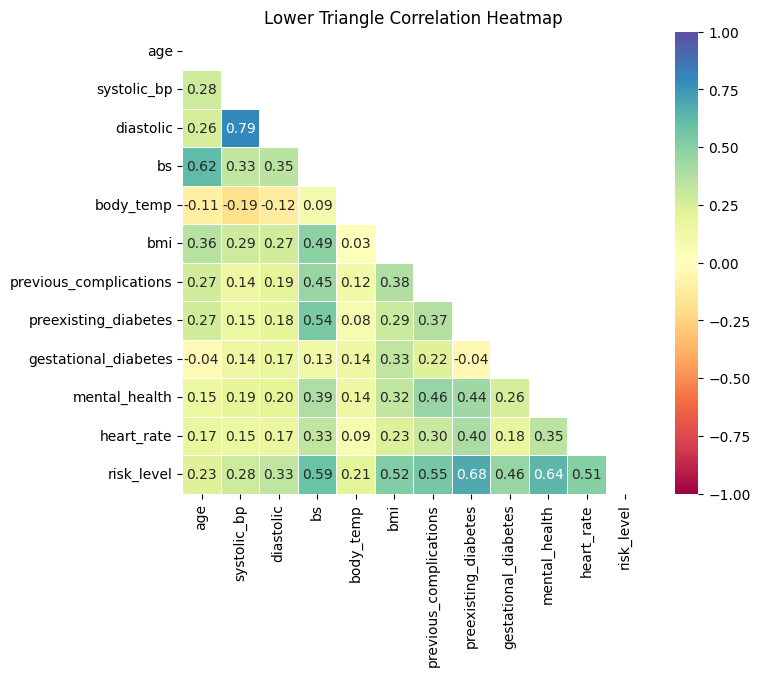

In [11]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cmap='Spectral', square=True, linewidths=.5)

plt.title('Lower Triangle Correlation Heatmap')
plt.show()

In [12]:
corr_with_target = (
    df.corr(numeric_only=True)[target]
    .drop(target)  # remove self-correlation
    .sort_values(ascending=False)
)

# Categorize by strength
def categorize_corr(c):
    if abs(c) >= 0.5:
        return "Strong (≥0.5)"
    elif abs(c) >= 0.3:
        return "Moderate (0.3–0.5)"
    elif abs(c) >= 0.1:
        return "Weak (0.1–0.3)"
    else:
        return "Negligible (<0.1)"

corr_df = pd.DataFrame({
    "Feature": corr_with_target.index,
    "Correlation": corr_with_target.values
})
corr_df["Strength"] = corr_df["Correlation"].apply(categorize_corr)

# Sort for presentation
corr_df = corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

print("📊 Correlation of Features with Target:\n")

display(corr_df.style.background_gradient(subset=["Correlation"], cmap='Spectral', vmin=-1, vmax=1).format({"Correlation": "{:.2f}"}))

📊 Correlation of Features with Target:



,Feature,Correlation,Strength
0,preexisting_diabetes,0.68,Strong (≥0.5)
1,mental_health,0.64,Strong (≥0.5)
2,bs,0.59,Strong (≥0.5)
3,previous_complications,0.55,Strong (≥0.5)
4,bmi,0.52,Strong (≥0.5)
5,heart_rate,0.51,Strong (≥0.5)
6,gestational_diabetes,0.46,Moderate (0.3–0.5)
7,diastolic,0.33,Moderate (0.3–0.5)
8,systolic_bp,0.28,Weak (0.1–0.3)
9,age,0.23,Weak (0.1–0.3)


## Distribution

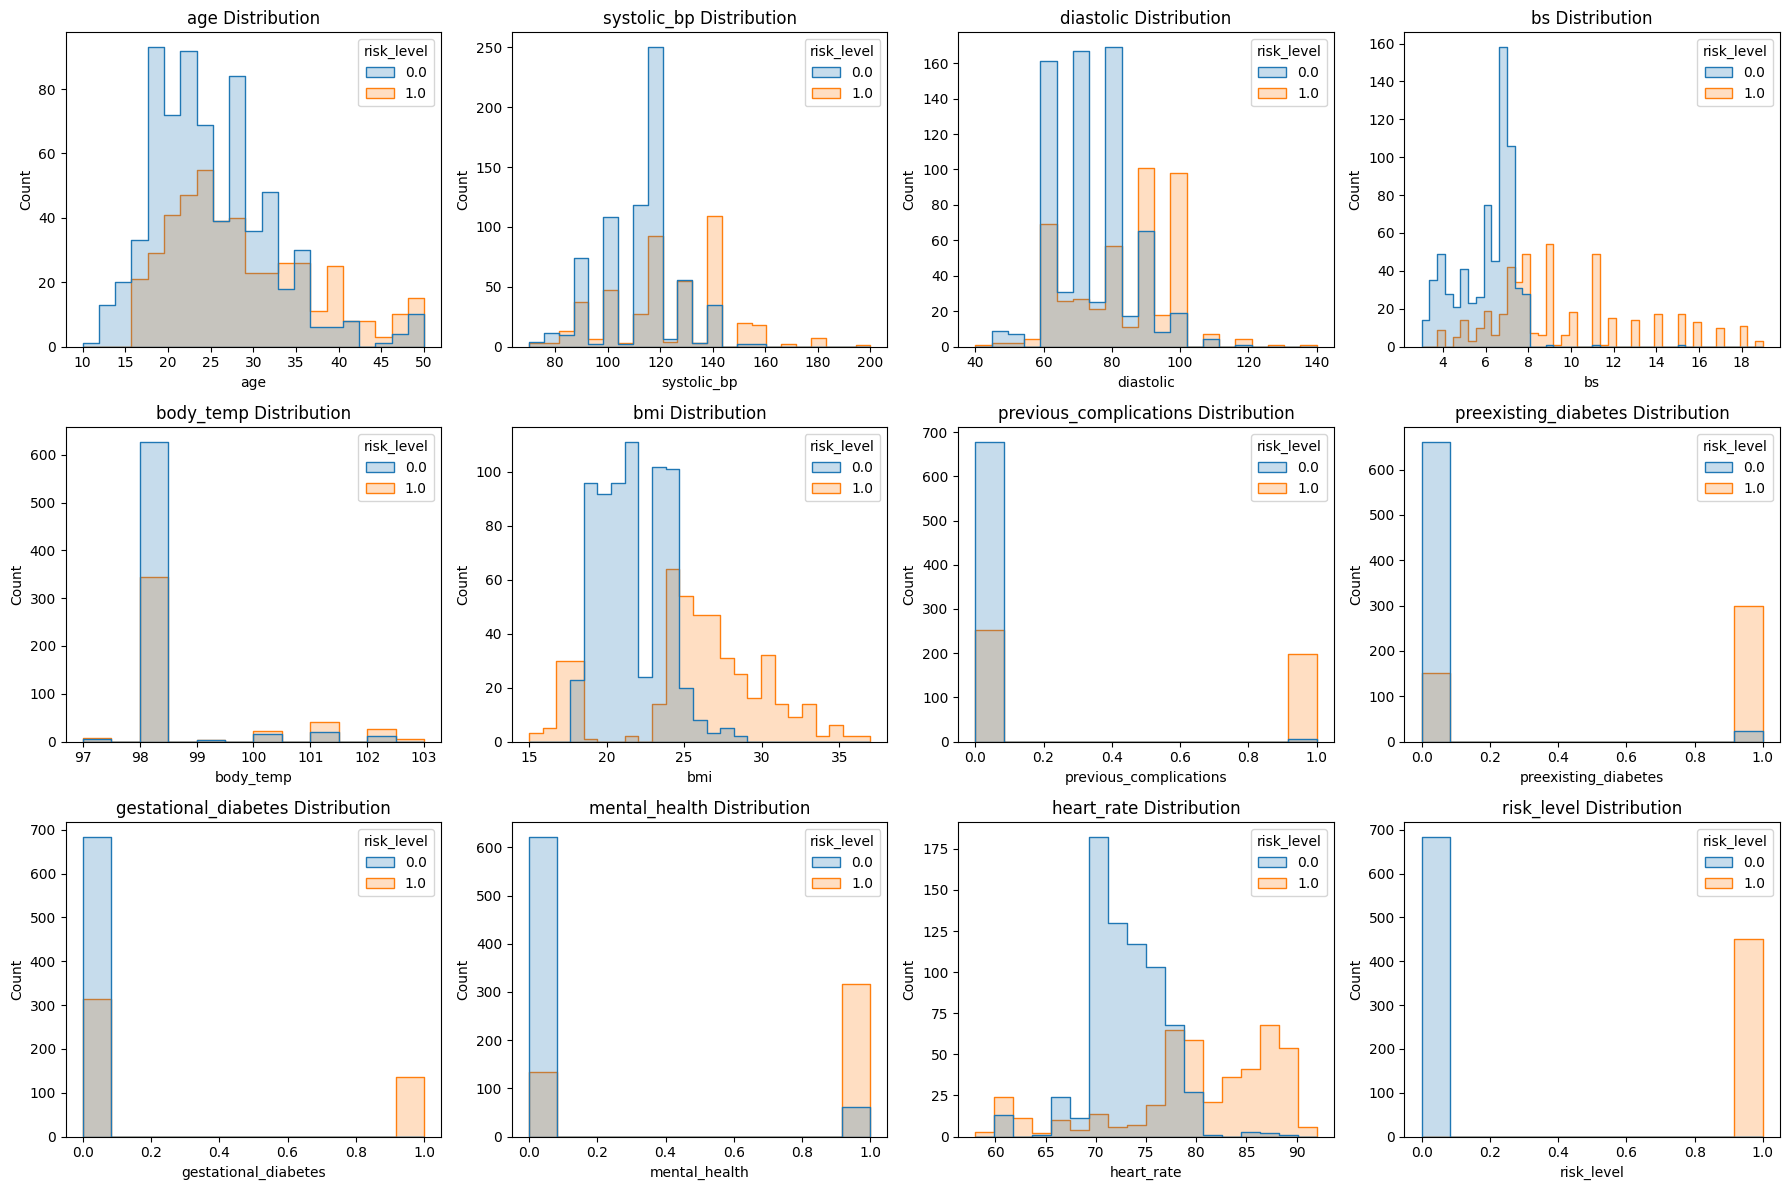

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(
        data=df,
        x=col,
        hue='risk_level',
        kde=False,
        ax=axes[i],
        element='step',
        stat='count'
    )
    axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

## Numerical features vs. risk level

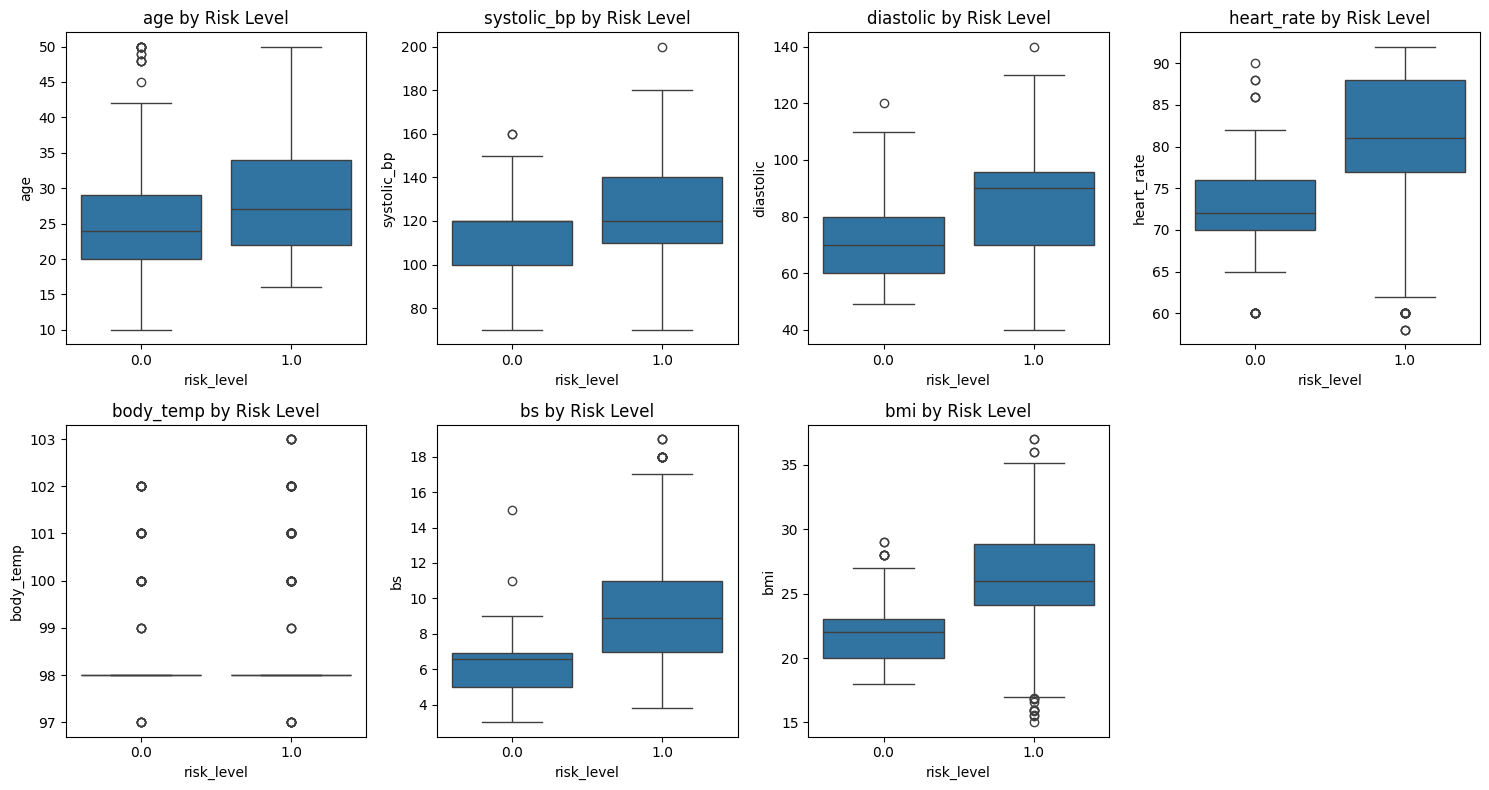

In [14]:
num_cols = ['age', 'systolic_bp', 'diastolic', 'heart_rate', 'body_temp', 'bs', 'bmi']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x='risk_level', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Risk Level')

axes[-1].axis('off')

plt.tight_layout()
plt.show()

Body temp shows very low variance and is uninformative. We can safely remove this feature

In [15]:
df = df.drop(columns=['body_temp'])

# Modeling

## Evaluation helpers

In [16]:
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

## Data split

In [17]:
# Perform 60/20/20 split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=67)

In [18]:
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]

## Random Forest

### Base model

In [19]:
rf = RandomForestClassifier(random_state=67)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Optimization

In [20]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [21]:
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=67,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)
best_rf_params = random_search_rf.best_params_

print("Best Parameters:", best_rf_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 9}


In [22]:
best_rf = RandomForestClassifier(random_state=67, **best_rf_params)
best_rf.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,9
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## XGBoost

### Base model

In [23]:
baseline_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=67
)

baseline_xgb.fit(X_train, y_train)

c:\Users\nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:37:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### Optimization

In [24]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=67),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)

best_xgb_params = random_search_xgb.best_params_
print("Best Parameters:", best_xgb_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}


c:\Users\nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
best_xgb = XGBClassifier(
    random_state=67,
    use_label_encoder=False,
    eval_metric='logloss',
    **best_xgb_params
)
best_xgb.fit(X_train, y_train)

c:\Users\nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Feature Importance

C:\Users\nikko\AppData\Local\Temp\ipykernel_33712\820964091.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nikko\AppData\Local\Temp\ipykernel_33712\820964091.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


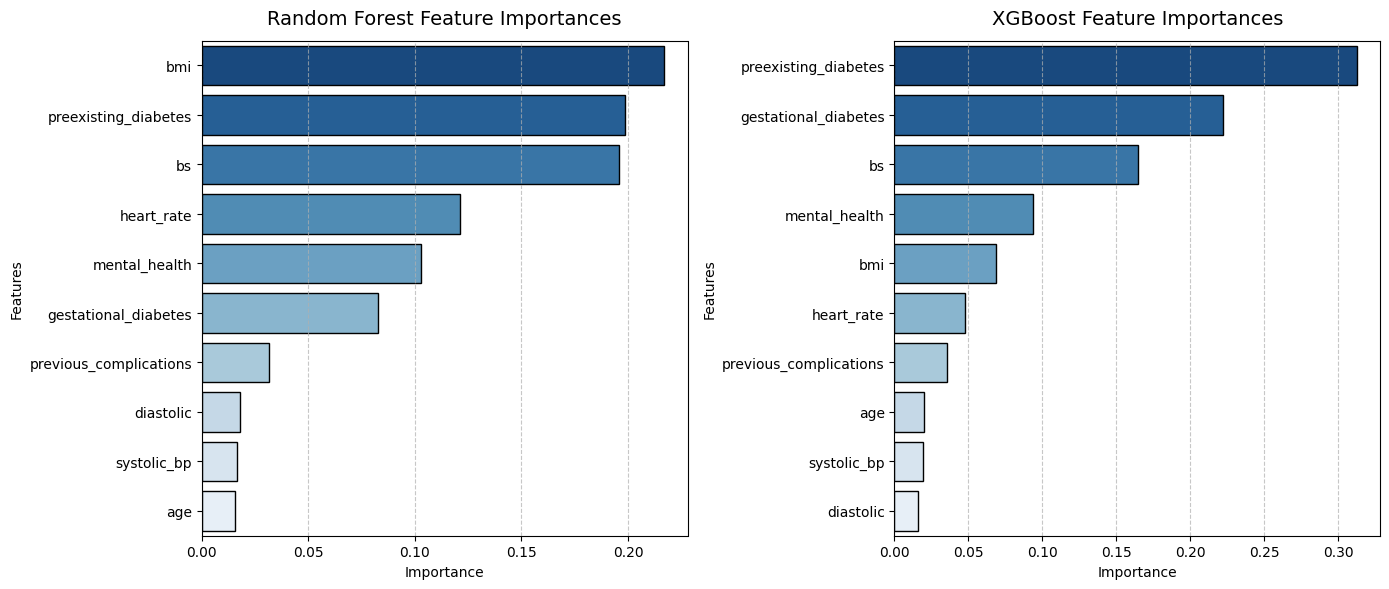

In [26]:
rf_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
xgb_importance = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest plot
sns.barplot(
    x=rf_importance.values,
    y=rf_importance.index,
    palette='Blues_r',
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('Random Forest Feature Importances', fontsize=14, pad=12)
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Features')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# XGBoost plot
sns.barplot(
    x=xgb_importance.values,
    y=xgb_importance.index,
    palette='Blues_r',
    edgecolor='black',
    ax=axes[1]
)
axes[1].set_title('XGBoost Feature Importances', fontsize=14, pad=12)
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Features')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Interestingly, XGBoost emphasized diabetes-related features while ignoring BMI, whereas Random Forest considered BMI the most important feature, followed by diabetes and heart rate.

# Evaluation

## Confusion matrix

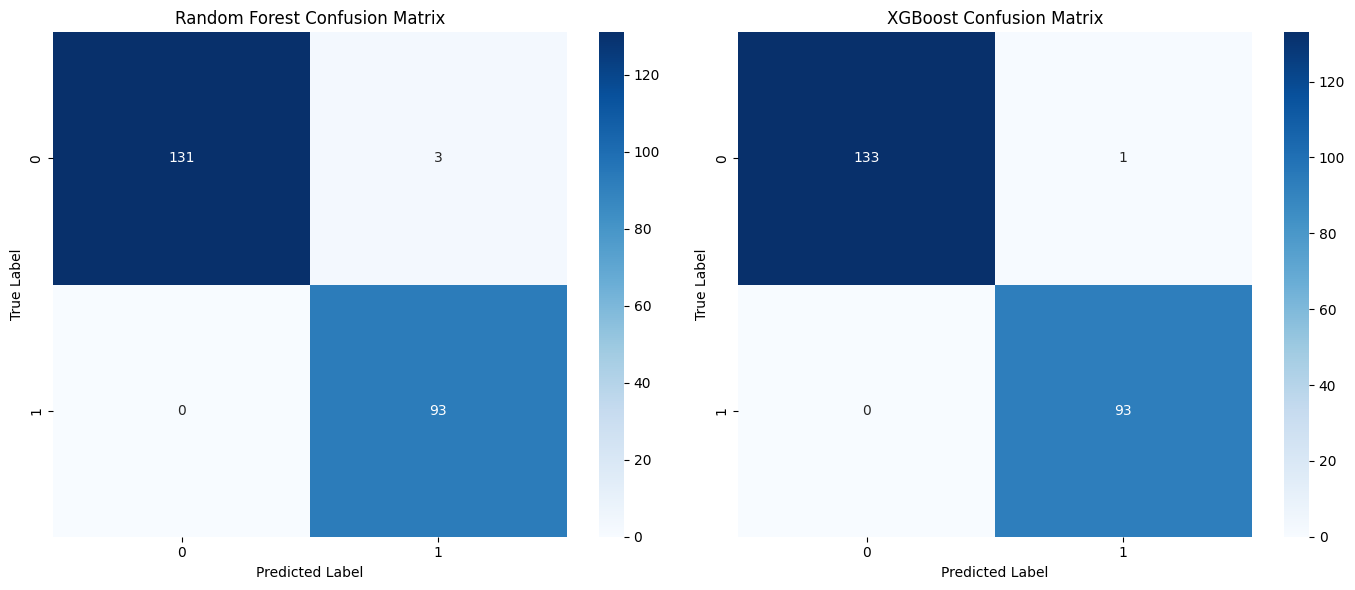

In [27]:
rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

cm_rf = confusion_matrix(y_test, rf_pred)
cm_xgb = confusion_matrix(y_test, xgb_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest plot
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# XGBoost plot
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


## Key metrics

In [28]:
rf_metrics = get_metrics(y_test, rf_pred)
xgb_metrics = get_metrics(y_test, xgb_pred)

metrics_df = pd.DataFrame([rf_metrics, xgb_metrics], index=['Random Forest', 'XGBoost'])

metrics_df

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.986784,0.987197,0.986784,0.986814
XGBoost,0.995595,0.995642,0.995595,0.995598


## Conclusion

During EDA, we removed outliers such as extremely high ages and invalid BMI entries, and excluded features with very low variance, like body temperature. These steps helped clean the dataset and focus the models on meaningful patterns. In terms of feature importance, XGBoost emphasized diabetes-related features, while Random Forest ranked BMI highest, followed by diabetes and heart rate. After these preprocessing steps, both models performed exceptionally well. Random Forest achieved an accuracy of 0.987, with similarly high precision, recall, and F1 score. XGBoost slightly outperformed it, reaching an accuracy of 0.996, with marginally higher scores across all metrics, indicating excellent predictive performance and generalization on the cleaned dataset.

# Exporting Model

In [29]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)